# Select fCpGs

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import linregress
import MolecularClocks.src.methylation_util as m_util
from MolecularClocks.src.invasiveCpGs_consts import getConsts
import util as local_util

consts = getConsts()

In [2]:
figure_outdir = 'figures'
output_dir = 'outputs'
if not os.path.exists(figure_outdir):
    os.mkdir(figure_outdir)
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

In [ ]:
neutral_DNA_CpG_list = local_util.getNeutralDNACpGs()
data = local_util.getDataDict()

## Generalizability/Sensitivity Tests

In [4]:
assert not data['tumor']['clinical'].loc[data['tumor']['beta_values'].columns.to_series().apply(lambda x:x[:-4]), 'reason_purity'].any()
assert data['tumor']['clinical'].loc[data['tumor']['beta_values'].columns.to_series().apply(lambda x:x[:-4]), 'in_CpG_dataset'].all()

In [5]:
# Test generalizability of the method

balanced_CpGs_only_ductals = local_util.gen_CpG_set(data, neutral_DNA_CpG_list, only_ductals=True)
balanced_CpGs_all_tumors = local_util.gen_CpG_set(data, neutral_DNA_CpG_list, only_ductals=False)

c_beta_only_ductals = 1 - data['tumor']['beta_values'].loc[balanced_CpGs_only_ductals].std(axis=0)
c_beta_all_tumors = 1 - data['tumor']['beta_values'].loc[balanced_CpGs_all_tumors].std(axis=0)

print(f'{np.intersect1d(balanced_CpGs_only_ductals, balanced_CpGs_all_tumors).shape[0]} sites shared')
print(f'r = {linregress(c_beta_only_ductals, c_beta_all_tumors).rvalue}')

439 sites shared
r = 0.9988851565799176


In [5]:
# Test sensitivity of the sites
# Pick 1000 most variable sites and divide them in half randomly
# Calculate c_beta for each tumor using each set of sites
# Calculate correlation between the two c_beta values for each tumor

balanced_CpGs_all_tumors = local_util.gen_CpG_set(data, neutral_DNA_CpG_list, only_ductals=False)

balanced_CpGs_all_tumors_1000 = local_util.gen_CpG_set(data, neutral_DNA_CpG_list, only_ductals=False, n_select=1000)
np.random.shuffle(balanced_CpGs_all_tumors_1000)

rand_split_1 = balanced_CpGs_all_tumors_1000[:500]
rand_split_2 = balanced_CpGs_all_tumors_1000[500:]

c_beta_all_tumors = 1 - data['tumor']['beta_values'].loc[balanced_CpGs_all_tumors].std(axis=0)
c_beta_rand_split_1 = 1 - data['tumor']['beta_values'].loc[rand_split_1].std(axis=0)
c_beta_rand_split_2 = 1 - data['tumor']['beta_values'].loc[rand_split_2].std(axis=0)

print(f'{np.intersect1d(rand_split_1, balanced_CpGs_all_tumors).shape[0]} original sites in rand split 1')
print(f'{np.intersect1d(rand_split_2, balanced_CpGs_all_tumors).shape[0]} original sites in rand split 2')

print(f'r = {linregress(c_beta_rand_split_1, c_beta_rand_split_2).rvalue}')

257 original sites in rand split 1
243 original sites in rand split 2
r = 0.9898923080868524


In [6]:
balanced_CpGs_1000_filepath = os.path.join(output_dir, 'balanced_CpGs_1000.txt')
if os.path.exists(balanced_CpGs_1000_filepath):
    existing_set = np.loadtxt(balanced_CpGs_1000_filepath, dtype=str)
    assert np.all(balanced_CpGs_all_tumors_1000 == existing_set)
    print('Current output matches existing file.')
else:
    np.savetxt(balanced_CpGs_1000_filepath, balanced_CpGs_all_tumors_1000, fmt='%s')
    print('Saved file.')

Saved file.


## Select 500 CpGs

In [4]:
balanced_CpGs_final_set = local_util.gen_CpG_set(data, neutral_DNA_CpG_list, only_ductals=False)

balanced_CpGs_filepath = os.path.join(output_dir, 'balanced_CpGs.txt')
if os.path.exists(balanced_CpGs_filepath):
    existing_set = np.loadtxt(balanced_CpGs_filepath, dtype=str)
    assert np.all(balanced_CpGs_final_set == existing_set)
    print('Current output matches existing file.')
else:
    np.savetxt(balanced_CpGs_filepath, balanced_CpGs_final_set, fmt='%s')

Current output matches existing file.


In [5]:
final_sample_set = data['tumor']['beta_values'].columns[data['tumor']['beta_values'].loc[balanced_CpGs_final_set].isna().mean(axis=0) <= 0.05]
n_before = data['tumor']['beta_values'].shape[1]
n_after = final_sample_set.shape[0]
print(f'{n_before - n_after} tumors were filtered for having >5% missing values for the 500 selected sites.')

11 tumors were filtered for having >5% missing values for the 500 selected sites.


In [6]:
c_beta_final_samples = 1 - data['tumor']['beta_values'].loc[balanced_CpGs_final_set, final_sample_set].std(axis=0)

c_beta_filepath = os.path.join(output_dir, 'cohort.T1.c_beta.txt')
if os.path.exists(c_beta_filepath):
    existing_c_beta = pd.read_table(c_beta_filepath, index_col=0, header=None).squeeze("columns")
    assert (c_beta_final_samples - existing_c_beta < 1e-6).all()
    print('Current output matches existing file.')
else:
    c_beta_final_samples.to_csv(c_beta_filepath, sep='\t', header=False)

Current output matches existing file.


In [8]:
data['tumor']['beta_values'].loc[balanced_CpGs_final_set].to_csv(
    os.path.join(local_util.TCGA_datadir, 'cohort1.methyl.balancedSites.tsv'),
    sep='\t'
)

## Figures

In [48]:
# Add beta_means, beta_stds, beta_nans to data dict
local_util.addMeanStdsNans(data)

### Visualization of Site Selection - Figures 1A and 1B

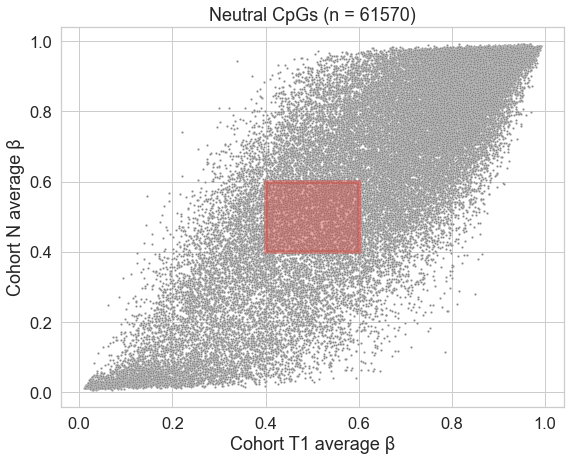

In [165]:
sns.set(rc={"savefig.bbox":'tight'}, font_scale=1.5, style='whitegrid')

fig, ax = plt.subplots(1, 1, figsize=(9, 7))

sns.scatterplot(ax=ax, x=data['tumor']['beta_means'].loc[neutral_DNA_CpG_list],
                y=data['normal']['beta_means'].loc[neutral_DNA_CpG_list], s=5,
                color=consts['palette_jco'][2]
               )
ax.set_xlabel('Cohort T1 average β')
ax.set_ylabel('Cohort N average β')
ax.set_title(f'Neutral CpGs (n = {len(neutral_DNA_CpG_list)})')

lower = 0.4
upper = 0.6

# ax.axvline(lower, lower, upper, color=color)
# ax.axvline(upper, lower, upper, color=color)
# ax.axhline(lower, lower, upper, color=color)
# ax.axhline(upper, lower, upper, color=color)

ax.fill([lower, upper, upper, lower], [lower, lower, upper, upper], alpha=0.5,
#         color='green',
        color=consts['palette_jco'][3],
        lw=4)

fig.savefig(os.path.join(figure_outdir, 'Figure_2_A.pdf'), format='pdf', pad_inches=0.1)

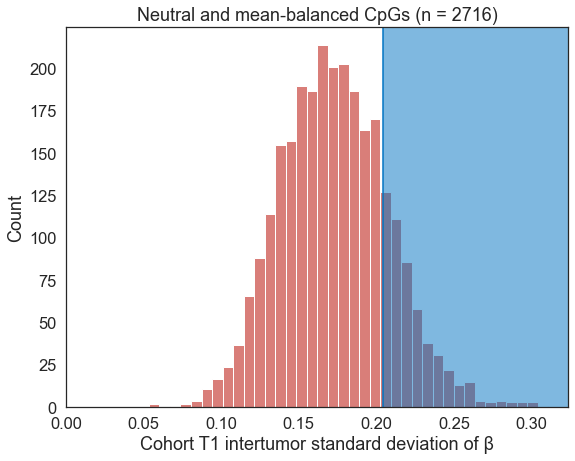

In [166]:
sns.set(rc={"savefig.bbox":'tight'}, font_scale=1.5, style='white')

fig, ax = plt.subplots(1, 1, figsize=(9, 7))

balanced_means_CpGs = m_util.getCpG_list(data, local_util.BALANCED_CRITERIA, starting_CpG_list=neutral_DNA_CpG_list)

sns.histplot(ax=ax, x=data['tumor']['beta_stds'].loc[balanced_means_CpGs],
#             color=consts['palette_jco'][2],
            color=consts['palette_jco'][3]
            )
ax.set_xlabel('Cohort T1 intertumor standard deviation of β')
ax.set_title(f'Neutral and mean-balanced CpGs (n = {len(balanced_means_CpGs)})')

color = consts['palette_jco'][0]

cutoff = data['tumor']['beta_stds'].loc[balanced_means_CpGs].sort_values()[-500]
ax.axvline(cutoff,
          color=color
          )

xmax = ax.get_xlim()[1]
ymax = ax.get_ylim()[1]

ax.fill([cutoff, xmax, xmax, cutoff], [0, 0, ymax, ymax], alpha=0.5,
#         color='green',
        color=color,
        lw=0)
ax.set_xlim(0, xmax)
ax.set_ylim(0, ymax)

fig.savefig(os.path.join(figure_outdir, 'Figure_2_B.pdf'), format='pdf', pad_inches=0.1)

### Display CpG Examples - Figure 2E

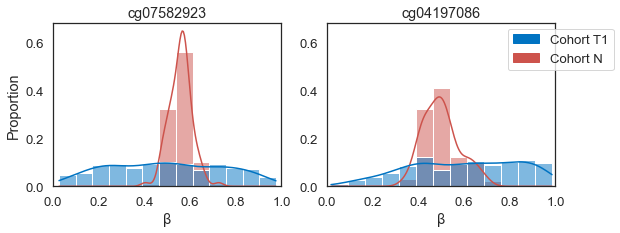

In [99]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3))

CpG_randSamp = np.random.choice(balanced_CpGs_final_set, 2, replace=False)
color_dict = {'Cohort T1':consts['palette_jco'][0], 'Cohort N':consts['palette_jco'][3]}
patches = [mpatches.Patch(color=color_dict[cohort], label=cohort) for cohort in color_dict.keys()]

plots_x, plots_y = axes[1].get_position().get_points()[1]
fig.legend(handles=patches,
           # title='',
           loc='upper right',
           bbox_to_anchor=(plots_x + .1, plots_y + .005)
           # bbox_to_anchor=(plots_x - .27, plots_y + .3)
          )

CpGs_chosen = ['cg07582923', 'cg04197086']

ymax_max = 0
for i, CpG in enumerate(CpGs_chosen):
    ax = axes[i]
    
    plot_data = pd.concat([
        pd.DataFrame({'beta':data['tumor']['beta_values_SELECTION'].loc[CpG], 'Cohort':'Cohort T1'}),
        pd.DataFrame({'beta':data['normal']['beta_values_SELECTION'].loc[CpG], 'Cohort':'Cohort N'})
    ], axis=0)
    sns.histplot(ax=ax, data=plot_data, x='beta', hue='Cohort',
                 kde=True,
                 common_norm=False, stat='proportion', palette = color_dict, legend=False)
    ax.set_title(CpG)
    ax.set_xlabel('β')

    ymax_max = max(ymax_max, ax.get_ylim()[1])

axes[0].set_ylim(0, ymax_max)
axes[1].set_ylim(0, ymax_max)

axes[0].set_xlim(0, 1)
axes[1].set_xlim(0, 1)

axes[1].set_ylabel('')

fig.savefig(os.path.join(figure_outdir, 'Figure_2_E.pdf'), format='pdf', pad_inches=0.1)

## Plot a sample of CpGs

In [164]:
m_util.plotCpGDists(
#     extra_title = f'{label}\n',
    CpG_list=CpG_list,
    outfile=True,
    outfile_name=outfile_name,
    outdir=outdir,
    dim=(6, 5)
)

NameError: name 'label' is not defined